In [ ]:
import os, sys
sys.path.append(os.path.abspath("/notebooks/AutoParser/squeezenet/models/slim/"))

from datasets import dataset_utils
import tensorflow as tf
slim = tf.contrib.slim

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"

# Specify where you want to download the model to
checkpoints_dir = 'Matify/VGG16/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [1]:
import tensorflow as tf
import sys 
import os
sys.path.append(os.path.abspath("/notebooks/AutoParser/squeezenet/models/slim/"))

from deployment import model_deploy
from datasets import dataset_factory
from preprocessing import preprocessing_factory
from tensorflow.python.ops import control_flow_ops
from MatifyDataset import MatifyDataset

slim = tf.contrib.slim
class args:
    num_gpus = 1
    data_dir = 'Matify/MatifyDataset/'
    output_training_dir = 'Matify/VGG16/Output'
    output_eval_dir = "Matify/VGG16/Output"
    checkpoint_dir = "Matify/VGG16/checkpoints"
    max_steps = 100000
    print_log_steps = 100
    save_summaries_secs = 60*2
    save_checkpoint_secs = 60*5
    eval_interval_secs = 60*2
    
    reader_threads = 2
    batch_size = 10
    preprocessing_threads = 6
    learning_rate = 0.01
    learning_rate_decay_steps = 5000
    learning_rate_decay = 0.75
    eval_device = 'gpu:0'
    
tf.logging.set_verbosity(tf.logging.INFO)
deploy_config = model_deploy.DeploymentConfig(num_clones=args.num_gpus)

Tensor("fifo_queue_Dequeue:0", shape=(10, 224, 224, 3), dtype=float32)
(10, 224, 224, 3)
(10, 10)


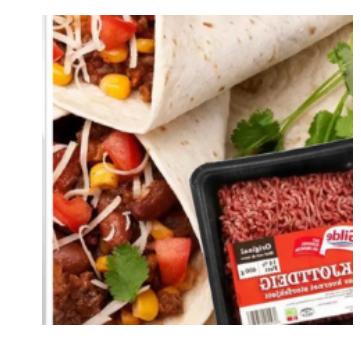

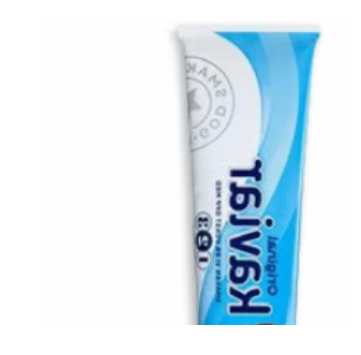

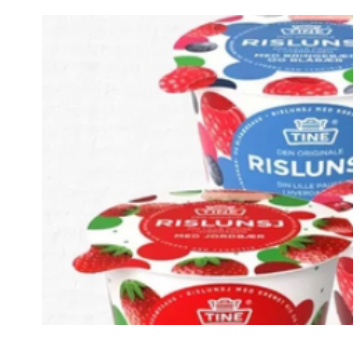

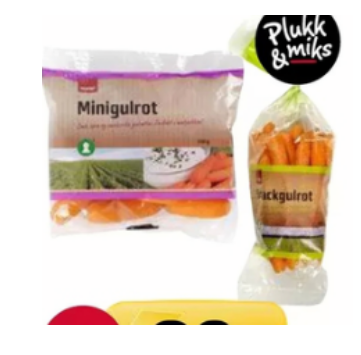

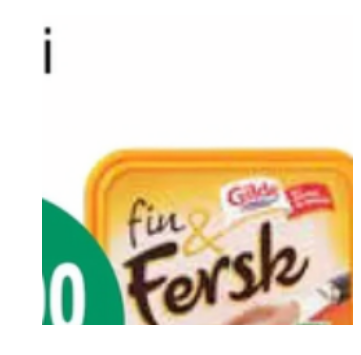

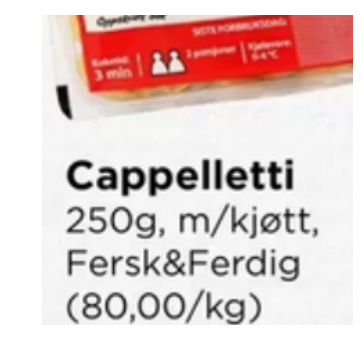

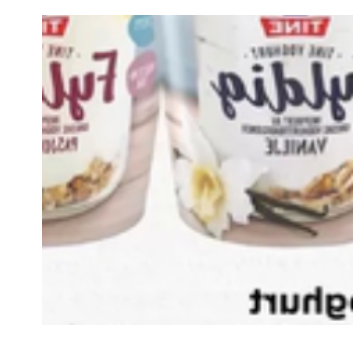

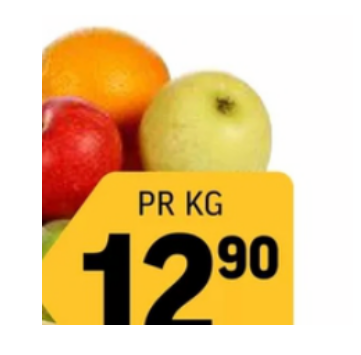

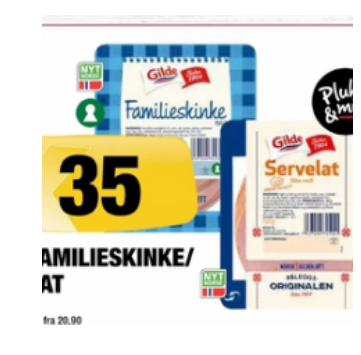

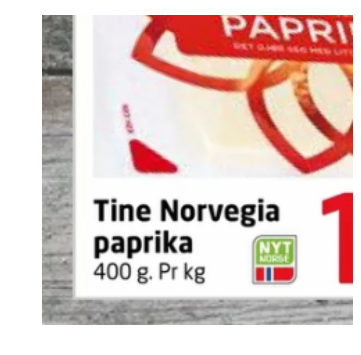

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors.CancelledError'>, Enqueue operation was cancelled
	 [[Node: batch/fifo_queue_enqueue = QueueEnqueue[Tcomponents=[DT_FLOAT, DT_INT64], _class=["loc:@batch/fifo_queue"], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](batch/fifo_queue, concat/_187, Reshape/_189)]]

Caused by op u'batch/fifo_queue_enqueue', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()


In [25]:
%matplotlib inline
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
from matplotlib import pyplot as plt
import numpy as np
with tf.Graph().as_default():
    matifyDataset = MatifyDataset(datasetDir = 'Matify/MatifyDataset/', nValidations = 20, verbose = False);
    dataset = matifyDataset.getSplit('train')
    #Data provider that read tfrecord files and return image and label tensor
    provider = slim.dataset_data_provider.DatasetDataProvider(
                      dataset,
                      num_readers=1,
                      common_queue_capacity=20 * 10,
                      common_queue_min=10 * 10)
    [image, label] = provider.get(['image', 'label'])
    image_preprocessing_fn = preprocessing_factory.get_preprocessing('vgg_16', is_training=True)

    #subgraph that preprocess the image
    image = image_preprocessing_fn(image, 224, 224)
    
    ##create tensor contain batck of images and labels
    images, labels = tf.train.batch(
          [image, label],
          batch_size=args.batch_size,
          num_threads=args.preprocessing_threads,
          capacity=5 * args.batch_size)
    labels = slim.one_hot_encoding(labels, matifyDataset.nClasses)
    ## Create a FIFOQueue to fetch batch in FIFO fashion
    batch_queue = slim.prefetch_queue.prefetch_queue(
          [images, labels], capacity=2 * deploy_config.num_clones)
    images, labels = batch_queue.dequeue()
    print images
    init_op = tf.initialize_all_variables()
    # Start input enqueue threads.
    coord = tf.train.Coordinator()
    
    with tf.Session() as sess:
        # Initialize the variables (like the epoch counter).
        sess.run(init_op)
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        xs, ys = sess.run([images, labels])
        
        print np.asarray(xs).shape
        print np.asarray(ys).shape
        means = [123.68, 116.779, 103.939]
        for x in xs:
            channels = np.split(np.asarray(x), 3, 2)
            for i in range(3):
                channels[i] += means[i]
            image = np.concatenate(channels, 2)
            plt.figure()
            plt.imshow(image.astype(np.uint8))
            plt.axis('off')
            plt.show()
        # Show the downloaded image
        

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = 'Matify/VGG16/checkpoints'

slim = tf.contrib.slim

# We need default size of image for a particular network.
# The network was trained on images of that size -- so we
# resize input image later in the code.
image_size = vgg.vgg_16.default_image_size


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    # Open specified url and load image as a string
    image_string = urllib2.urlopen(url).read()
    
    # Decode string into matrix with intensity values
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Resize the input image, preserving the aspect ratio
    # and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of
    # the network.
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                         image_size,
                                                         image_size,
                                                         is_training=False)
    
    # Networks accept images in batches.
    # The first dimension usually represents the batch size.
    # In our case the batch size is one.
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure
    # the batch norm parameters. arg_scope is a very conveniet
    # feature of slim library -- you can define default
    # parameters for layers -- like stride, padding etc.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                               num_classes=1000,
                               is_training=False)
    
    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)
    
    # Create a function that reads the network weights
    # from the checkpoint file that you downloaded.
    # We will run it in session later.
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        
        # Load weights
        init_fn(sess)
        
        # We want to get predictions, image as numpy matrix
        # and resized and cropped piece that is actually
        # being fed to the network.
        np_image, network_input, probabilities = sess.run([image,
                                                           processed_image,
                                                           probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities),
                                            key=lambda x:x[1])]
    
    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Show the image that is actually being fed to the network
    # The image was resized while preserving aspect ratio and then
    # cropped. After that, the mean pixel value was subtracted from
    # each pixel of that crop. We normalize the image to be between [-1, 1]
    # to show the image.
    plt.imshow( network_input / (network_input.max() - network_input.min()) )
    plt.suptitle("Resized, Cropped and Mean-Centered input to network",
                 fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Now we print the top-5 predictions that the network gives us with
        # corresponding probabilities. Pay attention that the index with
        # class names is shifted by 1 -- this is because some networks
        # were trained on 1000 classes and others on 1001. VGG-16 was trained
        # on 1000 classes.
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index+1]))
        
    res = slim.get_model_variables()